In [1]:
import numpy as np
import time
import os

import matplotlib.pyplot as plt
import pandas as pd
import random

import keras
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras import models

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_ENABLE_GPU_GARBAGE_COLLECTION"] = 'false'
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], False)

DEBUG = False

2022-01-30 22:19:53.789373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 22:19:53.861170: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 22:19:53.861352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
column_names = ['timestamp','open','close','high','low','volume','adosc','atr','macd','macd_signal','macd_hist','mfi','upper_band','middle_band','lower_band','rsi','difference_low_high','difference_open_close','target']
bin_directory = '/home/joren/Coding/cryptodata/Normalized_labelled/'
bin_directory_2 = '/home/joren/Coding/cryptodata/1MIN/'
csv_directory = '/home/joren/Coding/cryptodata/1MIN/'
frame_size = 320


In [3]:
## read random binary file
def random_file(dir):
    filenames = []
    for file in os.listdir(dir):
        filename = os.fsdecode(file)
        filenames.append(filename)
        
    randomname = filenames[random.randint(0, len(filenames)-1)]
    if randomname.endswith(".bin") or randomname.endswith(".csv"): 
        print(f"reading file: {os.path.join(dir, randomname)}")
        return os.path.join(dir, randomname), randomname

field_info = [
    { "type": np.uint64, "count": 1 },
    { "type": np.double, "count": 17 },
    { "type": np.int64, "count": 1 }
]
BYTES_EIGHT = 8

def read_bin_full_file(file):
    f = open(file, 'rb')
    b = f.read(-1)

    BYTES_TO_READ = 0
    for field in field_info:
        BYTES_TO_READ += BYTES_EIGHT * field["count"]

    data = []
    BYTES_READ = 0
    for i in range(0, int(os.path.getsize(file) / BYTES_TO_READ)):
        row = []

        for idx, field in enumerate(field_info):
            row += np.frombuffer(b, dtype=field["type"], count=field["count"], offset=BYTES_READ).tolist()

            BYTES_READ += BYTES_EIGHT * field["count"]

        data.append(row)
    return np.array(data, dtype=np.float16)



field_info2 = [
    { "type": np.uint64, "count": 1 },
    { "type": np.double, "count": 5 }
]
BYTES_EIGHT = 8

def read_bin_full_file_original(file):
    f = open(file, 'rb')
    b = f.read(-1)

    BYTES_TO_READ = 0
    for field in field_info2:
        BYTES_TO_READ += BYTES_EIGHT * field["count"]

    print("Reading", BYTES_TO_READ, "bytes / row")

    data = []
    BYTES_READ = 0
    for i in range(0, int(os.path.getsize(file) / BYTES_TO_READ)):
        row = []

        for idx, field in enumerate(field_info2):
            row += np.frombuffer(b, dtype=field["type"], count=field["count"], offset=BYTES_READ).tolist()

            BYTES_READ += BYTES_EIGHT * field["count"]

        data.append(row)

    return data

In [4]:
# train-test split
def df_split(df):  
    X = df.drop(columns=['timestamp','target'], axis=0).to_numpy()
    Y = df['target'].to_numpy()

    X_test = []
    y_test = []
    for i in range(frame_size, X.shape[0]): 
        X_test.append(X[i-frame_size:i])
        y_test.append(Y[i])
    X_test, y_test = np.array(X_test, dtype=np.float16), np.array(y_test, dtype=np.float16)

    return X_test, y_test

In [5]:
## load
model = models.load_model('./models/model_small_10')

2022-01-30 22:19:54.147884: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-30 22:19:54.148843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 22:19:54.149046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 22:19:54.149181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [6]:
## prepare data for prediction
file, filename = random_file(bin_directory)
data = read_bin_full_file(file)
df2 = pd.DataFrame(data, columns=column_names)
df2.fillna(0, inplace=True)
startloc = round(len(df2)*0.9)
df = df2.iloc[startloc:]

reading file: /home/joren/Coding/cryptodata/Normalized_labelled/ICPUSDT.bin


In [ ]:
X_test, y_test = df_split(df)

In [ ]:
## predict
y_pred = np.array(model.predict(X_test), dtype=np.float16)

y_pred = np.argmax(y_pred, axis=-1)
y_pred = y_pred.flatten()

print(f"""
Class. report:
{classification_report(y_test, y_pred)}
""")
cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100)

2022-01-30 16:10:21.364984: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8300



Class. report:
              precision    recall  f1-score   support

         0.0       1.00      0.41      0.58     75940
         1.0       0.01      0.75      0.02       265
         2.0       0.01      0.82      0.01       264

    accuracy                           0.41     76469
   macro avg       0.34      0.66      0.21     76469
weighted avg       0.99      0.41      0.57     76469


[[30812 15640 29488]
 [   56   200     9]
 [   45     3   216]]
40.83746354731983


1618381440000.0
1622995560000.0


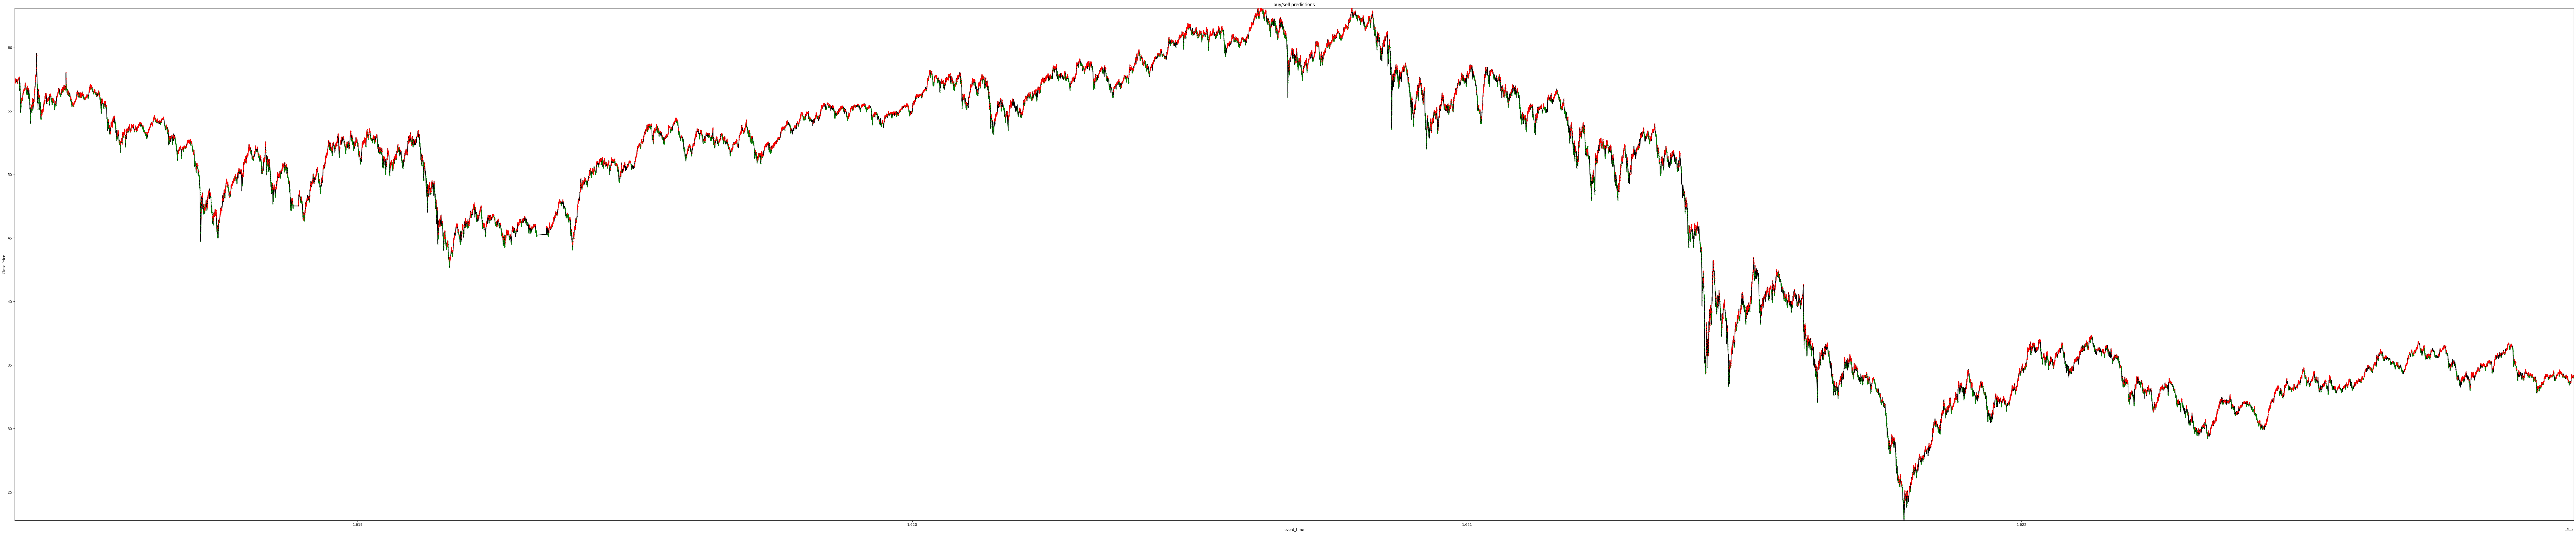

In [11]:
## plot predicted data against binary data
df = pd.read_csv(os.path.join(csv_directory, filename[:-3]+'csv'))
df = df.iloc[startloc+frame_size+1:]
df['predictions'] = np.array(y_pred)

# df = df.iloc[round(len(df)*0.5):]
print(df.iloc[0]['event_time'])
print(df.iloc[-1]['event_time'])

# ensuring only equity series is considered
time_name = 'event_time'  #'event_time'
timestamps = pd.to_datetime(df[time_name])
close = df['close']

#Using matplotlib to add required columns
plt.figure(figsize=(100,20), dpi=100)
plt.margins(0,0)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

plt.plot(df[time_name], close, linewidth=2, color='black', zorder=1)

#Identifying the buy/sell zone
df['Buy'] = np.where( (df['predictions'] == 1), 1, 0)
df['Sell'] = np.where( (df['predictions'] == 2), 1, 0)

# df = fix_predictions(df)

## plotting the buy and sellsignals on graph
plt.scatter(df.loc[df['Buy'] ==1 , time_name].values,df.loc[df['Buy'] ==1, 'close'].values, label='skitscat', color='green', s=3, marker="^", zorder=2)
plt.scatter(df.loc[df['Sell'] ==1 , time_name].values,df.loc[df['Sell'] ==1, 'close'].values, label='skitscat', color='red', s=3, marker="v", zorder=3)

## Adding labels
plt.xlabel(time_name)
plt.ylabel('Close Price')
plt.title('buy/sell predictions')

# Saving image
# plt.savefig('images/graph.png')
plt.savefig('images/graph.png', dpi=100)



In [8]:
## plot targets
## plot predicted data against binary data
# https://stackoverflow.com/questions/8409095/set-markers-for-individual-points-on-a-line-in-matplotlib

file, filename = random_file(bin_directory)
data = read_bin_full_file(file)
df = pd.DataFrame(data, columns=column_names)
df2 = pd.read_csv(os.path.join(csv_directory, filename[:-3]+'csv'))
df2 = df2.iloc[1:]
df['close'] = df2['close']

# df = pd.read_csv(os.path.join(csv_directory, filename[:-3]+'csv'))
# df = df.iloc[481:]
# df['predictions'] = np.array(y_pred)

# df = df.iloc[round(len(df)*0.80):]

# ensuring only equity series is considered
time_name = 'timestamp'  #'event_time'
timestamps = pd.to_datetime(df[time_name])
close = df['close']

#Using matplotlib to add required columns
plt.figure(figsize=(100,20), dpi=200)
plt.margins(0,0)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

plt.plot(df[time_name], close, linewidth=2, color='black', zorder=1)

#Identifying the buy/sell zone
df['Buy'] = np.where( (df['target'] == 1), 1, 0)
df['Sell'] = np.where( (df['target'] == 2), 1, 0)

## plotting the buy and sellsignals on graph
plt.scatter(df.loc[df['Buy'] ==1 , time_name].values,df.loc[df['Buy'] ==1, 'close'].values, label='skitscat', color='green', s=3, marker="^", zorder=2)
plt.scatter(df.loc[df['Sell'] ==1 , time_name].values,df.loc[df['Sell'] ==1, 'close'].values, label='skitscat', color='red', s=3, marker="v", zorder=3)

## Adding labels
plt.xlabel(time_name)
plt.ylabel('Close Price')
plt.title('buy/sell predictions') 

# Saving image
# plt.savefig('images/graph.png')
plt.savefig('images/graph.png', dpi=200)



reading file: /home/joren/Coding/cryptodata/Normalized_labelled/QNTUSDT.bin


In [29]:
## plot predicted data against binary data
data = read_bin_full_file_original(os.path.join(bin_directory_2, filename))
df = pd.DataFrame(data, columns=column_names[:6])

loc = startloc+frame_size
df = df.iloc[loc:]

df['predictions'] = np.array(y_pred)

df = df.iloc[round(len(df)*0.75):]

# ensuring only equity series is considered
time_name = 'timestamp'  #'event_time'
timestamps = pd.to_datetime(df[time_name])
close = df['close']

#Using matplotlib to add required columns
plt.figure(figsize=(100,20), dpi=300)
plt.margins(0,0)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

plt.plot(df[time_name], close, linewidth=2, color='black', zorder=1)

#Identifying the buy/sell zone
df['Buy'] = np.where( (df['predictions'] == 1), 1, 0)
df['Sell'] = np.where( (df['predictions'] == 2), 1, 0)

# df = fix_predictions(df)

## plotting the buy and sellsignals on graph
plt.scatter(df.loc[df['Buy'] ==1 , time_name].values,df.loc[df['Buy'] ==1, 'close'].values, label='skitscat', color='green', s=3, marker="^", zorder=2)
plt.scatter(df.loc[df['Sell'] ==1 , time_name].values,df.loc[df['Sell'] ==1, 'close'].values, label='skitscat', color='red', s=3, marker="v", zorder=3)

## Adding labels
plt.xlabel(time_name)
plt.ylabel('Close Price')
plt.title('buy/sell predictions')

# Saving image
# plt.savefig('images/graph.png')
plt.savefig('images/graph.png', dpi=300)

Reading 48 bytes / row
